# Local Indicators of Spatial Association <a name="lisa"></a>

This python notebook presents code to make a LISA map using Local Moran's I. It contains limited text on how the code works or what it is doing. 

## Setup

First load required libraries

In [1]:
# Graphics
import matplotlib.pyplot as plt
from matplotlib import colors

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
import numpy as np

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In ths notebook we'll used data for the results of the UK Brexit vote, as [provided](https://geographicdata.science/book/data/brexit/brexit_cleaning.html) by Rey *et al.* (2020). There are two distinct datasets that will need to be loaded and combined:

- Electoral Comission data on vote percentages at the local authority level. [CSV]
- ONS Local Authority Districts (December 2016) Generalised Clipped Boundaries in the UK WGS84. 

First load the vote percentage data as a pandas df:

In [2]:
brexit_data_path = '../../data/brexit/brexit_vote.csv'
ref = pd.read_csv(brexit_data_path, index_col='Area_Code')
ref.head()

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08


Next load the local authority district boundaries as a geopandas geodf:

In [3]:
lads = gpd.read_file("../../data/brexit/local_authority_districts.geojson").set_index('lad16cd')
lads.head()

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


And then `join` the df to the geodf (the two df have the same index, using local autority district codes) and select only the columns we need for the analysis:

In [4]:
gdf = gpd.GeoDataFrame(lads.join(ref[['Pct_Leave']]), crs=lads.crs)
gdf = gdf[['objectid', 'lad16nm', 'Pct_Leave', 'geometry']].dropna()
gdf.head()

,objectid,lad16nm,Pct_Leave,geometry
lad16cd,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."


Let's quickly visualise the leave vote percentage data:

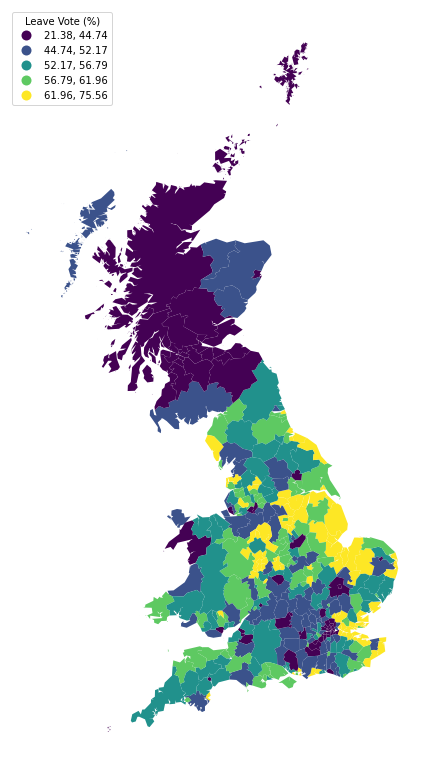

In [5]:
fig, ax = plt.subplots(1, figsize=(14, 14))
gdf.plot(column='Pct_Leave', cmap='viridis', 
        scheme='quantiles', k=5, 
        linewidth=0., 
        legend=True, legend_kwds={"title":"Leave Vote (%)","loc": 2},
        ax=ax
       )
ax.set_axis_off()

# Local Indicators of Spatial Association <a name="lisa"></a>

The Moran's $I$ value we have seen above gives us a measure of spatial autocorrelation across the whole map for our variable of interest. It is said to be a *global* measure of spatial autocorrelation. While it can tell us in whether observations of similar values are generally clustered or dispersed, it cannot tell us *where* that clustering or dispersion is more or less pronounced across the map. 

For example, in the map of leave vote percentage (above) we might think that Scotland is a cluster of low values, while the east of England is a cluster of high values. But the global Moran's $I$ value we have calculated so far can't help us confirm or deny these suspicions. To investigate patterns like these we need to consider *local* measures of spatial autocorrelation.  

These local measures consider each individual observation and have become known as [Local Indicators of Spatial Association](http://doi.org/10.1111/j.1538-4632.1995.tb00338.x), or LISAs for short. LISAs allow us to understand how indvidual locations are related to their neighbours in ways that might be different to other locations. As we will see there are four general types:

1. *hot spots* are cluster locations with high values whose neighbours also have high values
2. *cold spots* are cluster locations with low values whose neighbours also have low values
3. *doghnuts* are outlier locations with low values surrounded by neighbours with high values
4. *diamonds* (in the rough) are outlier locations with high values surrounded by neighbours with low values

Identifying such locations also demands that we consider if local measures are statistically significant. 

First, create a row-standardised weights matrix

In [6]:
w = weights.KNN.from_dataframe(gdf, k=8)
w.transform = 'R'

To calculate Local Moran's $I$ values, we can use the PySAL [`Moran_Local` function](https://pysal.org/esda/generated/esda.Moran_Local.html), passing our variable of interest with our row-standardized spatial weights matrix:

In [7]:
lisa = esda.moran.Moran_Local(gdf['Pct_Leave'], w)

We have just calculated a Moran's $I$ value for every location in the map. These are stored in the `.Is` attribute of the `Moran_Local` object. Let's use that to create a map of the Local $I$s, first creating a new Series in our GeoDataFrame, then plotting it:

We'll use 95% confidence here and create a new Series in our GeoDataFrame that indicates if the Local $I$ for each location is 'non-significant' or 'significant':

In [8]:
gdf['p-sim'] = lisa.p_sim

sig = 1 * (lisa.p_sim < 0.05)
slabels = ['non-sig.', 'significant'] 
labels = [slabels[i] for i in sig]

gdf['sig'] = labels
gdf[['sig','p-sim']].head(10)

,sig,p-sim
lad16cd,,
E06000001,significant,0.025
E06000002,significant,0.015
E06000003,significant,0.017
E06000004,significant,0.008
E06000010,significant,0.004
E06000011,significant,0.019
E06000032,non-sig.,0.223
E06000005,significant,0.020
E06000006,non-sig.,0.391


*But* we only want to plot the significant locations. The following code assigns values 0-4 to locations:

- 0 for non-significant locations
- 1 is a hot spot (HH)
- 2 is a doughnut (LH)
- 3 is a cold spot (LL)
- 4 is a diamond (HL)

In [9]:
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 non-sig.', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

And now create a new Series in our GeoDataFrame using the labels we created:

In [10]:
gdf['slabels'] = labels
[(spot_label, (gdf['slabels']==spot_label).sum()) for spot_label in spot_labels]

[('0 non-sig.', 216),
 ('1 hot spot', 82),
 ('2 doughnut', 9),
 ('3 cold spot', 69),
 ('4 diamond', 4)]

Finally, we can plot our map!

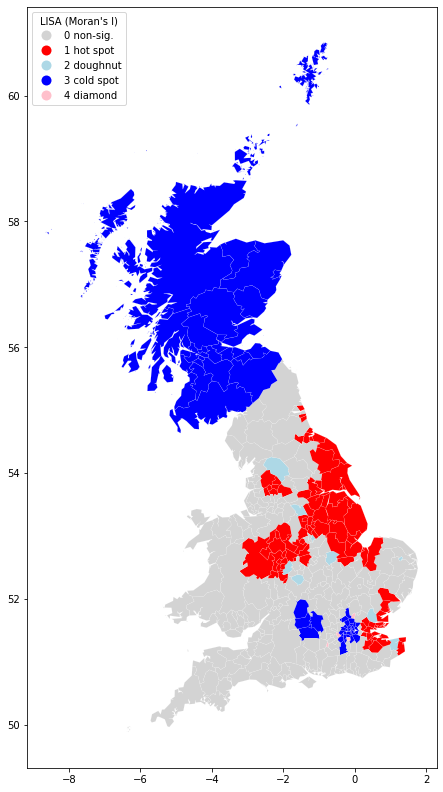

In [11]:
fig, ax = plt.subplots(1, figsize=(14,14))

sigcolors = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])

gdf.plot(column='slabels', categorical=True,
         k=2, cmap=sigcolors, linewidth=0.1, edgecolor='white', 
         legend=True, legend_kwds={"title":"LISA (Moran's I)","loc": 2},
         ax=ax)
plt.show()

Rey et al. (2020) [interpret](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html) this final map nicely:

> In bright red, we find those [LADs] with an unusual concentration of high Leave proportions surrounded also by high Leave results. This corresponds with areas in the East and center of the map. 
>
> In light red, we find the first type of spatial outliers: areas that still voted to Leave in high proportions, despite being surrounded by areas with more modest support for Leave. These correspond with some of the peripheral areas of London ...
>
>In darker blue we can see the spatial clusters of low support for the Leave campaign, which include London, Oxford and most of Scotland. 
>
>Finally, in light blue we find the other type of spatial outlier: areas with lower percentages of Leave votes nearby areas of high concentration of supporters for Leave

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).